# Train ResNet-50 classification on cervix images

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
from datetime import datetime
import numpy as np

In [3]:
# Project
import sys
sys.path.append(os.path.join(os.path.abspath(os.path.dirname('.')), '..', 'common'))

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

def plt_st(n, m):
    plt.figure(figsize=(n, m))

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
from resnet_keras122 import get_resnet_original

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5110)


In [6]:
from training_utils import get_trainval_id_type_lists

print("\n {} - Get train/val lists ...".format(datetime.now()))
train_id_type_list, val_id_type_list = get_trainval_id_type_lists()

cervix_train_id_type_list = [(id_type[0], id_type[1] + '_cervix') for id_type in train_id_type_list if id_type[0] != '1339']
cervix_val_id_type_list = [(id_type[0], id_type[1] + '_cervix') for id_type in val_id_type_list if id_type[0] != '1339']
len(cervix_train_id_type_list), len(cervix_val_id_type_list)


 2017-04-09 17:16:56.705296 - Get train/val lists ...
Train dataset contains : 
('-', [175, 546, 315], ' images of corresponding types')
Validation dataset contains : 
('-', [75, 234, 135], ' images of corresponding types')


(1635, 702)

In [18]:
print("\n {} - Get ResNet-50 model ...".format(datetime.now()))
resnet = get_resnet_original(opt='adadelta')


 2017-04-09 18:57:58.353139 - Get ResNet-50 model ...


In [12]:
resnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 230, 230)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 64, 112, 112)  9472        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 64, 112, 112)  256         conv1[0][0]                      
___________________________________________________________________________________________

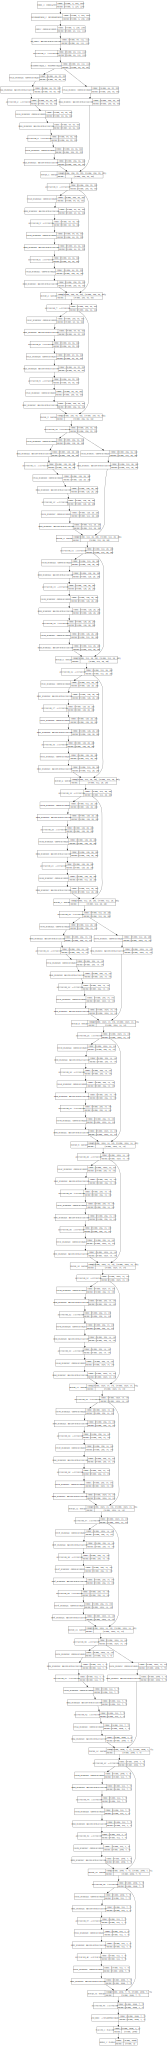

In [9]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

graph = model_to_dot(resnet, True, True)
SVG(graph.create(prog='dot', format='svg'))

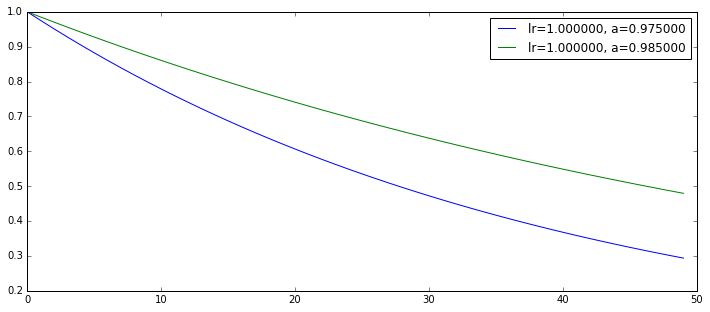

In [19]:
from training_utils import exp_decay

lr_1 = 1.0; a_1 = 0.975
lr_2 = 1.0; a_2 = 0.985

epochs = np.arange(0, 50)
lrs_1 = exp_decay(epochs, lr=lr_1, a=a_1)
lrs_2 = exp_decay(epochs, lr=lr_2, a=a_2)
plt_st(12, 5)
plt.plot(epochs, lrs_1, label="lr=%f, a=%f" % (lr_1, a_1))
plt.plot(epochs, lrs_2, label="lr=%f, a=%f" % (lr_2, a_2))
plt.legend()

In [20]:
seed = 2017
np.random.seed(seed)
save_prefix='resnet_not_trained_original_norm_cervix_adadelta_seed=%i' % seed

In [28]:
from glob import glob

weights_files = glob("weights/%s*.h5" % save_prefix)
best_val_loss = 1e5
best_weights_filename = ""
for f in weights_files:
    index = os.path.basename(f).index('-')
    loss = float(os.path.basename(f)[index+1:-4])
    if best_val_loss > loss:
        best_val_loss = loss
        best_weights_filename = f
print("Best val loss weights: ", best_weights_filename)


if len(best_weights_filename) > 0:
    # load weights to the model
    print("Load found weights: ", best_weights_filename)
    resnet.load_weights(best_weights_filename)

('Best val loss weights: ', 'weights/resnet_not_trained_original_norm_cervix_adadelta_seed=2017_04-0.9335.h5')
('Load found weights: ', 'weights/resnet_not_trained_original_norm_cervix_adadelta_seed=2017_04-0.9335.h5')


In [22]:
from xy_providers import DataCache
cache = DataCache(2000)

In [23]:
if True:
    from training_utils import classification_train as train
      
    nb_epochs = 50
    batch_size = 4
    
    lrate_decay_f = lambda epoch: exp_decay(epoch, lr=lr_1, a=a_1) 

    print("\n {} - Start training ...".format(datetime.now()))
    h = train(resnet, 
              cervix_train_id_type_list, 
              cervix_val_id_type_list, 
              nb_epochs=nb_epochs,
              lrate_decay_f=lrate_decay_f,
              batch_size=batch_size, 
              xy_provider_cache=cache,
              seed=seed,
              save_prefix=save_prefix)    


 2017-04-09 19:03:11.804081 - Start training ...

-- Training parameters: 4, 50, 2048, 1024

-- Fit stats of train dataset
1635/1635 [==============================] - 30s    

-- Fit model
Epoch 1/50
2048/2048 [==============================] - 558s - loss: 1.7960 - acc: 0.3213 - val_loss: 2.9557 - val_acc: 0.4971
Epoch 2/50
2048/2048 [==============================] - 552s - loss: 1.2545 - acc: 0.3315 - val_loss: 1.0997 - val_acc: 0.5137
Epoch 3/50
2048/2048 [==============================] - 538s - loss: 1.1362 - acc: 0.3887 - val_loss: 1.0760 - val_acc: 0.4463
Epoch 4/50
2048/2048 [==============================] - 566s - loss: 1.0892 - acc: 0.4316 - val_loss: 0.9991 - val_acc: 0.5049
Epoch 5/50
2048/2048 [==============================] - 558s - loss: 1.0567 - acc: 0.4414 - val_loss: 0.9335 - val_acc: 0.5889
Epoch 6/50
2048/2048 [==============================] - 554s - loss: 1.0286 - acc: 0.4702 - val_loss: 0.9849 - val_acc: 0.5430
Epoch 7/50
2048/2048 [=========================

In [15]:
if True:
    from training_utils import classification_train as train
      
    nb_epochs = 10
    batch_size = 4
    
    lrate_decay_f = lambda epoch: exp_decay(epoch, lr=lr_1, a=a_1) 

    print("\n {} - Start training ...".format(datetime.now()))
    h = train(resnet, 
              cervix_train_id_type_list, 
              cervix_val_id_type_list, 
              nb_epochs=nb_epochs,
              lrate_decay_f=lrate_decay_f,
              batch_size=batch_size, 
              xy_provider_cache=cache,
              seed=seed,
              save_prefix=save_prefix)    


 2017-04-08 18:11:03.611189 - Start training ...
('-- Training parameters: ', 4, 10, 2048, 1024)
-- Fit stats of train dataset
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/resnet_not_trained_original_cervix_adadelta_seed=2017_stats.npz
No need to recompute statistics
-- Fit model
Epoch 1/10
2048/2048 [==============================] - 522s - loss: 0.9615 - acc: 0.5171 - val_loss: 1.0862 - val_acc: 0.5830
Epoch 2/10
2048/2048 [==============================] - 517s - loss: 0.9674 - acc: 0.5151 - val_loss: 1.0229 - val_acc: 0.5596
Epoch 3/10
2048/2048 [==============================] - 517s - loss: 0.9446 - acc: 0.5327 - val_loss: 0.9858 - val_acc: 0.6152
Epoch 4/10
2048/2048 [==============================] - 516s - loss: 0.9536 - acc: 0.5278 - val_loss: 0.9851 - val_acc: 0.6006
Epoch 5/10
2048/2048 [==============================] - 516s - loss: 0.9229 - acc: 0.5479 - val_loss: 1.5721 - val_acc: 0.5732
Epoch 6/10
2048/2048 [====================

In [25]:
from training_utils import classification_validate as validate
from test_utils import classification_predict as predict

batch_size = 4

In [29]:
print("\n {} - Start validation ...".format(datetime.now()))
validate(resnet, cervix_val_id_type_list, save_prefix=save_prefix, batch_size=batch_size, xy_provider_cache=cache)


 2017-04-09 20:45:26.866718 - Start validation ...
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/resnet_not_trained_original_norm_cervix_adadelta_seed=2017_stats.npz
('--', 4, 'batch loss : ', 1.8936181, ' | info:', array([('619', 'Type_1_cervix'), ('577', 'Type_2_cervix'),
       ('627', 'Type_3_cervix'), ('620', 'Type_1_cervix')], dtype=object))
('--', 8, 'batch loss : ', 1.2254896, ' | info:', array([('581', 'Type_2_cervix'), ('628', 'Type_3_cervix'),
       ('623', 'Type_1_cervix'), ('584', 'Type_2_cervix')], dtype=object))
('--', 12, 'batch loss : ', 1.0538673, ' | info:', array([('629', 'Type_3_cervix'), ('624', 'Type_1_cervix'),
       ('586', 'Type_2_cervix'), ('63', 'Type_3_cervix')], dtype=object))
('--', 16, 'batch loss : ', 1.4285734, ' | info:', array([('641', 'Type_1_cervix'), ('588', 'Type_2_cervix'),
       ('630', 'Type_3_cervix'), ('643', 'Type_1_cervix')], dtype=object))
('--', 20, 'batch loss : ', 0.92018688, ' | info:', arra

In [31]:
print("\n {} - Start predictions and write submission ...".format(datetime.now()))
from test_utils import get_test_id_type_list
test_id_type_list = get_test_id_type_list()
cervix_test_id_type_list = [(id_type[0], id_type[1] + '_cervix') for id_type in test_id_type_list]
predict(resnet, cervix_test_id_type_list, save_prefix=save_prefix, info=save_prefix, batch_size=batch_size)


 2017-04-09 20:47:29.987760 - Start predictions and write submission ...
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/resnet_not_trained_original_norm_cervix_adadelta_seed=2017_stats.npz
('--', 0, '/', 512)
('--', 4, '/', 512)
('--', 8, '/', 512)
('--', 12, '/', 512)
('--', 16, '/', 512)
('--', 20, '/', 512)
('--', 24, '/', 512)
('--', 28, '/', 512)
('--', 32, '/', 512)
('--', 36, '/', 512)
('--', 40, '/', 512)
('--', 44, '/', 512)
('--', 48, '/', 512)
('--', 52, '/', 512)
('--', 56, '/', 512)
('--', 60, '/', 512)
('--', 64, '/', 512)
('--', 68, '/', 512)
('--', 72, '/', 512)
('--', 76, '/', 512)
('--', 80, '/', 512)
('--', 84, '/', 512)
('--', 88, '/', 512)
('--', 92, '/', 512)
('--', 96, '/', 512)
('--', 100, '/', 512)
('--', 104, '/', 512)
('--', 108, '/', 512)
('--', 112, '/', 512)
('--', 116, '/', 512)
('--', 120, '/', 512)
('--', 124, '/', 512)
('--', 128, '/', 512)
('--', 132, '/', 512)
('--', 136, '/', 512)
('--', 140, '/', 512)
('--', 

## Analyse predictions

In [39]:
batch_size = 4
from data_utils import GENERATED_DATA
from xy_providers import cached_image_label_provider
from preprocessing.image.generators import ImageDataGenerator

normalize_data = True
image_size = (224, 224)
channels_first = True

xy_provider = cached_image_label_provider
val_gen = ImageDataGenerator(featurewise_center=normalize_data,
                             featurewise_std_normalization=normalize_data)

if normalize_data:
    assert len(save_prefix) > 0, "WTF"
    # Load mean, std, principal_components if file exists
    filename = os.path.join(GENERATED_DATA, save_prefix + "_stats.npz")
    assert os.path.exists(filename), "WTF"
    print("Load existing file: %s" % filename)
    npzfile = np.load(filename)
    val_gen.mean = npzfile['mean']
    val_gen.std = npzfile['std']

flow = val_gen.flow(xy_provider(cervix_val_id_type_list,
                                image_size=image_size,
                                channels_first=channels_first,
                                cache=cache,
                                test_mode=True),
                    # Ensure that all batches have the same size
                    len(cervix_val_id_type_list),
                    batch_size=batch_size)
total_counter = 0

Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/resnet_not_trained_original_norm_cervix_adadelta_seed=2017_stats.npz


('--', 24)
(('635', 'Type_3_cervix'), array([ 0.15936527,  0.32198155,  0.51865321], dtype=float32))
(('649', 'Type_1_cervix'), array([ 0.79851526,  0.17808865,  0.0233961 ], dtype=float32))
(('592', 'Type_2_cervix'), array([ 0.05966479,  0.21819711,  0.72213817], dtype=float32))
(('636', 'Type_3_cervix'), array([ 0.07021399,  0.20739347,  0.7223925 ], dtype=float32))


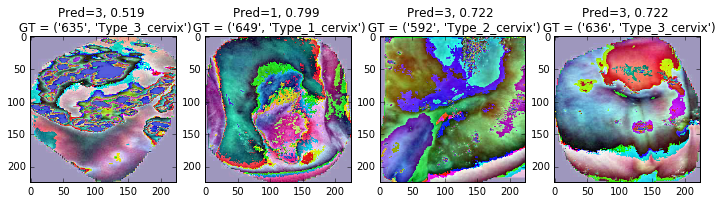

In [45]:
for x, y_true, info in flow:
    s = y_true.shape[0]
    y_pred = resnet.predict(x)
    print("--", total_counter*batch_size + s)    
    total_counter += 1
    plt_st(12, 4)
    for i in range(s):
        print(info[i], y_pred[i])
        plt.subplot(1, s, i+1)
        plt.title("Pred={}, {:.3f} \n GT = {}".format(np.argmax(y_pred[i])+1, np.max(y_pred[i]), info[i]))
        plt.imshow(x[i, :, :, :].transpose([1, 2, 0]))
    break

### Logs

Previous training : Cuda 8, CuDNN 5.1, rgb_2_green random threshold = 0.90

Normalized data

```
 2017-04-09 19:03:11.804081 - Start training ...

-- Training parameters: 4, 50, 2048, 1024

-- Fit stats of train dataset
1635/1635 [] - 30s    

-- Fit model
Epoch 1/50
2048/2048 [] - 558s - loss: 1.7960 - acc: 0.3213 - val_loss: 2.9557 - val_acc: 0.4971
Epoch 2/50
2048/2048 [] - 552s - loss: 1.2545 - acc: 0.3315 - val_loss: 1.0997 - val_acc: 0.5137
Epoch 3/50
2048/2048 [] - 538s - loss: 1.1362 - acc: 0.3887 - val_loss: 1.0760 - val_acc: 0.4463
Epoch 4/50
2048/2048 [] - 566s - loss: 1.0892 - acc: 0.4316 - val_loss: 0.9991 - val_acc: 0.5049
Epoch 5/50
2048/2048 [] - 558s - loss: 1.0567 - acc: 0.4414 - val_loss: 0.9335 - val_acc: 0.5889
Epoch 6/50
2048/2048 [] - 554s - loss: 1.0286 - acc: 0.4702 - val_loss: 0.9849 - val_acc: 0.5430
Epoch 7/50
2048/2048 [] - 534s - loss: 1.0012 - acc: 0.4819 - val_loss: 0.9348 - val_acc: 0.6055
Epoch 8/50
2048/2048 [] - 532s - loss: 0.9948 - acc: 0.5044 - val_loss: 1.0058 - val_acc: 0.5234
Epoch 9/50
2048/2048 [] - 532s - loss: 0.9707 - acc: 0.5024 - val_loss: 1.0069 - val_acc: 0.5293
Epoch 10/50
2048/2048 [] - 530s - loss: 0.9579 - acc: 0.5215 - val_loss: 0.9754 - val_acc: 0.5615
```

Previous training : Cuda 8, CuDNN 5.1, rgb_2_green random threshold = 0.90
Unnormalized data
```
2017-04-09 17:17:00.474796 - Start training ...

-- Training parameters: 4, 50, 2048, 1024

-- Fit model
Epoch 1/50
2048/2048 [] - 520s - loss: 1.8017 - acc: 0.3164 - val_loss: 1.8775 - val_acc: 0.4717
Epoch 2/50
2048/2048 [] - 520s - loss: 1.2634 - acc: 0.3257 - val_loss: 1.3348 - val_acc: 0.4775
Epoch 3/50
2048/2048 [] - 520s - loss: 1.1542 - acc: 0.3784 - val_loss: 1.3288 - val_acc: 0.3262
Epoch 4/50
2048/2048 [] - 541s - loss: 1.1114 - acc: 0.4131 - val_loss: 1.3522 - val_acc: 0.3789
Epoch 5/50
2048/2048 [] - 552s - loss: 1.0925 - acc: 0.4180 - val_loss: 1.0394 - val_acc: 0.5215
Epoch 6/50
2048/2048 [] - 549s - loss: 1.0626 - acc: 0.4321 - val_loss: 0.9966 - val_acc: 0.5166
Epoch 7/50
2048/2048 [] - 529s - loss: 1.0235 - acc: 0.4702 - val_loss: 1.0447 - val_acc: 0.5723
Epoch 8/50
2048/2048 [] - 534s - loss: 1.0368 - acc: 0.4614 - val_loss: 0.9533 - val_acc: 0.5225
Epoch 9/50
2048/2048 [] - 529s - loss: 1.0105 - acc: 0.4741 - val_loss: 1.0414 - val_acc: 0.5312
Epoch 10/50
2048/2048 [] - 528s - loss: 0.9947 - acc: 0.4961 - val_loss: 1.1979 - val_acc: 0.5205
```


Previous training : Cuda 7.5, CuDNN 5.0, rgb_2_green random threshold = 0.75
Normalized data

```
 2017-04-08 11:08:08.272038 - Start training ...
('-- Training parameters: ', 4, 50, 2048, 1024)
-- Fit stats of train dataset
1632/1635 [] - ETA: 0s-- Fit model
Epoch 1/50
2048/2048 [] - 533s - loss: 1.8080 - acc: 0.3193 - val_loss: 3.0369 - val_acc: 0.3438
Epoch 2/50
2048/2048 [] - 548s - loss: 1.3241 - acc: 0.3252 - val_loss: 2.2526 - val_acc: 0.4902
Epoch 3/50
2048/2048 [] - 547s - loss: 1.1718 - acc: 0.3506 - val_loss: 1.1362 - val_acc: 0.4316
Epoch 4/50
2048/2048 [] - 537s - loss: 1.1373 - acc: 0.3779 - val_loss: 1.0298 - val_acc: 0.4707
Epoch 5/50
2048/2048 [] - 531s - loss: 1.0760 - acc: 0.4126 - val_loss: 1.1794 - val_acc: 0.4668
Epoch 6/50
2048/2048 [] - 530s - loss: 1.0447 - acc: 0.4678 - val_loss: 1.1371 - val_acc: 0.5195
Epoch 7/50
2048/2048 [] - 527s - loss: 1.0200 - acc: 0.4692 - val_loss: 1.1386 - val_acc: 0.5254
Epoch 8/50
2048/2048 [] - 538s - loss: 1.0292 - acc: 0.4697 - val_loss: 0.9740 - val_acc: 0.5215
Epoch 9/50
2048/2048 [] - 530s - loss: 1.0012 - acc: 0.4819 - val_loss: 1.0669 - val_acc: 0.5527
Epoch 10/50
2048/2048 [] - 520s - loss: 0.9974 - acc: 0.4819 - val_loss: 1.0026 - val_acc: 0.5635
Epoch 11/50
2048/2048 [] - 518s - loss: 0.9839 - acc: 0.5049 - val_loss: 1.0388 - val_acc: 0.5557
Epoch 12/50
2048/2048 [] - 518s - loss: 0.9762 - acc: 0.5034 - val_loss: 1.0117 - val_acc: 0.5674
Epoch 13/50
2048/2048 [] - 517s - loss: 0.9598 - acc: 0.5093 - val_loss: 0.9964 - val_acc: 0.5781
Epoch 14/50
2048/2048 [] - 516s - loss: 0.9701 - acc: 0.5229 - val_loss: 1.0514 - val_acc: 0.5566
Epoch 15/50
2048/2048 [] - 517s - loss: 0.9534 - acc: 0.5361 - val_loss: 1.0541 - val_acc: 0.5879
Epoch 16/50
2048/2048 [] - 516s - loss: 0.9585 - acc: 0.5229 - val_loss: 1.0886 - val_acc: 0.5879
Epoch 17/50
2048/2048 [] - 517s - loss: 0.9333 - acc: 0.5459 - val_loss: 0.9377 - val_acc: 0.5771
Epoch 18/50
2048/2048 [] - 516s - loss: 0.9490 - acc: 0.5308 - val_loss: 0.9546 - val_acc: 0.5664
Epoch 19/50
2048/2048 [] - 516s - loss: 0.9364 - acc: 0.5444 - val_loss: 1.1033 - val_acc: 0.5742
Epoch 20/50
2048/2048 [] - 517s - loss: 0.9230 - acc: 0.5527 - val_loss: 1.0360 - val_acc: 0.5371
Epoch 21/50
2048/2048 [] - 517s - loss: 0.9203 - acc: 0.5469 - val_loss: 1.1179 - val_acc: 0.5605
Epoch 22/50
2048/2048 [] - 516s - loss: 0.9270 - acc: 0.5361 - val_loss: 1.0780 - val_acc: 0.5430
Epoch 23/50
2048/2048 [] - 517s - loss: 0.8984 - acc: 0.5605 - val_loss: 0.9682 - val_acc: 0.5840
Epoch 24/50
2048/2048 [] - 516s - loss: 0.9170 - acc: 0.5522 - val_loss: 0.9865 - val_acc: 0.5674
Epoch 25/50
2048/2048 [] - 517s - loss: 0.8988 - acc: 0.5723 - val_loss: 1.0542 - val_acc: 0.5693
Epoch 26/50
2048/2048 [] - 517s - loss: 0.9060 - acc: 0.5557 - val_loss: 1.0403 - val_acc: 0.5762
Epoch 27/50
2048/2048 [] - 517s - loss: 0.8849 - acc: 0.5786 - val_loss: 1.0366 - val_acc: 0.5342
Epoch 28/50
2048/2048 [] - 520s - loss: 0.8997 - acc: 0.5605 - val_loss: 1.2258 - val_acc: 0.5645
Epoch 29/50
2048/2048 [] - 518s - loss: 0.8930 - acc: 0.5664 - val_loss: 0.9811 - val_acc: 0.5840
Epoch 30/50
2048/2048 [] - 534s - loss: 0.8929 - acc: 0.5903 - val_loss: 0.9811 - val_acc: 0.5830
Epoch 31/50
2048/2048 [] - 534s - loss: 0.8890 - acc: 0.5586 - val_loss: 0.9574 - val_acc: 0.5742
Epoch 32/50
2048/2048 [] - 523s - loss: 0.8863 - acc: 0.5718 - val_loss: 1.0328 - val_acc: 0.5674
Epoch 33/50
2048/2048 [] - 535s - loss: 0.8800 - acc: 0.5718 - val_loss: 1.0850 - val_acc: 0.5654
Epoch 34/50
2048/2048 [] - 535s - loss: 0.8672 - acc: 0.5762 - val_loss: 1.0598 - val_acc: 0.5674
Epoch 35/50
2048/2048 [] - 529s - loss: 0.8587 - acc: 0.5815 - val_loss: 1.1162 - val_acc: 0.5625
Epoch 36/50
2048/2048 [] - 543s - loss: 0.8665 - acc: 0.5845 - val_loss: 1.0567 - val_acc: 0.5938
Epoch 37/50
2048/2048 [] - 534s - loss: 0.8702 - acc: 0.5806 - val_loss: 0.9536 - val_acc: 0.5938
Epoch 38/50
2048/2048 [] - 539s - loss: 0.8509 - acc: 0.5879 - val_loss: 1.0244 - val_acc: 0.5625
Epoch 39/50
2048/2048 [] - 524s - loss: 0.8657 - acc: 0.5786 - val_loss: 0.9551 - val_acc: 0.5557
Epoch 40/50
2048/2048 [] - 522s - loss: 0.8777 - acc: 0.5815 - val_loss: 0.9343 - val_acc: 0.5938
Epoch 41/50
2048/2048 [] - 525s - loss: 0.8505 - acc: 0.5967 - val_loss: 0.9645 - val_acc: 0.5908
Epoch 42/50
2048/2048 [] - 527s - loss: 0.8575 - acc: 0.5825 - val_loss: 1.0464 - val_acc: 0.6055
Epoch 43/50
2048/2048 [] - 520s - loss: 0.8454 - acc: 0.5962 - val_loss: 1.0261 - val_acc: 0.5576
Epoch 44/50
2048/2048 [] - 516s - loss: 0.8595 - acc: 0.5840 - val_loss: 0.9385 - val_acc: 0.5898
Epoch 45/50
2048/2048 [] - 520s - loss: 0.8458 - acc: 0.6006 - val_loss: 0.9334 - val_acc: 0.5977
Epoch 46/50
2048/2048 [] - 526s - loss: 0.8484 - acc: 0.6050 - val_loss: 1.2641 - val_acc: 0.5527
Epoch 47/50
2048/2048 [] - 530s - loss: 0.8519 - acc: 0.5923 - val_loss: 0.9114 - val_acc: 0.6006
```